# This notebook is for modeling both scan directions together and calculating the chisquare statistic for 1, 2, and 3-T models

In [3]:
from preamble import *

  0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
def lnprob(parameters=None,**kwargs):

    T_phot, R_star, D_star = parameters
    ln_like = 0

    # Boundary conditions for parameters to ensure physical validity
    c1 = (3300 <= T_phot <= 4200)
    c2 = (0.7 <= R_star <= 0.88)
    c3 = (9.708 <= D_star <= 9.720)
    if (c1 and c2 and c3):
        
        # Set parameters in lmfit
        model_params = lmfit.Parameters()
        model_params.add('T_phot', value=T_phot)
        model_params.add('R_star', value=R_star)
        model_params.add('D_star', value=D_star)
        solid_angle = (( (R_star * u.R_sun)/(D_star*u.parsec) ).decompose() )**2

        for direction in ['Forward','Reverse']:
            data_flux = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['f']
            data_wave= WFC3_Median_Spectra[f'{visit}'][f'{direction}']['w']
            data_err = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['e']
    
            # Generate model based on these parameters for both scan directions
            _model_flux = bintogrid(btsettl_wavelengths, spectral_model(model_params, filter_sigma), newx=data_wave.value)['y']
            model_flux = _model_flux * solid_angle
            # Calculate residuals and log-likelihood for both directions
            residuals = data_flux.value - model_flux
            err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err.value)))

            ln_like += (err_weight - 0.5*np.nansum((residuals / data_err.value) ** 2) )
            
        return ln_like

    else:
        return -np.inf  # Return log-probability of -inf outside bounds

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 1
speclibrary = 'btsettl'
spectral_model = btsettl_1T
nwalkers = 100
nsteps = 2000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:
    print(f"Processing {visit} (both directions)\n")
    
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel

    wave_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['w']
    wave_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['w']
    flux_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['f']
    flux_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['f']
    err_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['e']
    err_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['e']

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(wave_fwd.value)
    all_data['calibrated_flux'].append(flux_fwd.value)
    all_data['calibrated_flux_err'].append(err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(wave_rev.value)
    all_data['calibrated_flux'].append(flux_rev.value)
    all_data['calibrated_flux_err'].append(err_rev.value)

    # MCMC setup
    """EDIT THESE LINES"""
    Tphot_init = np.random.uniform(3600,3750,nwalkers)
    Rstar_init = np.random.uniform(0.8, 0.86, nwalkers)
    Dstar_init = np.random.uniform(9.712, 9.716, nwalkers)
    p0 = np.transpose([Tphot_init, Rstar_init, Dstar_init])

    ndim = 3
    burnin = int(0.5*nsteps)
    """"""""""""""""""""""""
    
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnprob, 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    result = sampler.run_mcmc(p0, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',int((nsteps-burnin)*nwalkers/tau_f))
    
    # Make corner plot
    rng = 0.9995
    """EDIT THESE LINES"""
    variable_names = ['T_phot', 'R_star', 'D_star']
    """"""""""""""""""""""""
    fig = corner.corner( 
        samples.T,show_titles=True, labels=variable_names,
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    """EDIT THESE LINES"""
    T_phot_sam, R_star_sam, D_star_sam = samples
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    sig1_D_star = np.percentile(D_star_sam, [15.9, 50., 84.1])

    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("T_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    print("\nD_star:")
    print(f"  Median (50th percentile): {sig1_D_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_D_star[1] - sig1_D_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_D_star[2] - sig1_D_star[1]:.3f}")
    
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])
    mcmc_model_params.add('D_star', value=sig1_D_star[1])
    """"""""""""""""""""""""

    # Calculate the max likelihood model for both scan directions
    solid_angle = (( (sig1_R_star[1] * u.R_sun)/(sig1_D_star[1]*u.parsec) ).decompose() )**2
    best_model = spectral_model(mcmc_model_params, filter_sigma) * solid_angle    
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(btsettl_wavelengths, best_model, newx=wave_fwd.value)['y']
    model_flux_mcmc_rev = bintogrid(btsettl_wavelengths, best_model, newx=wave_rev.value)['y']

    # Calculate residuals for both scan directions
    residuals_fwd = flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = flux_rev.value - model_flux_mcmc_fwd
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / err_fwd.value,
        residuals_rev / err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(flux_fwd.value) + len(flux_rev.value)
    dof_combined = total_data_points - ndim
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

# Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]
plt.title(f'{ncomponents}T BT-SETTL Decomposition Results')

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()

Processing F21 (both directions)

Running MCMC sampler...


  3%|▎         | 61/2000 [00:16<08:56,  3.61it/s]Traceback (most recent call last):
  File "/opt/anaconda3/envs/fleckopy/lib/python3.10/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/vq/zxq380ws52q37mjjtbt9c7rh0000gp/T/ipykernel_93166/2819384726.py", line 25, in lnprob
    _model_flux = bintogrid(btsettl_wavelengths, spectral_model(model_params, filter_sigma), newx=data_wave.value)['y']
  File "/Users/wiwa8630/Desktop/Projects/AUMic_15836/WFC3-analysis/modeling/preamble.py", line 278, in btsettl_1T
    convolved = convolve_spectrum(model_wave, model_flux, sigma=sigma, method = convolution_method, kernel_type = kernel_type)
  File "/Users/wiwa8630/Desktop/Projects/AUMic_15836/WFC3-analysis/modeling/preamble.py", line 142, in convolve_spectrum
    kernel = Gaussian1DKernel(stddev=sigma.value).array
  File "/opt/anaconda3/envs/fleckopy/lib/python3.10/site-packages/astropy/convolution/kernels.py", line 94, in __i

emcee: Exception while calling your likelihood function:
  params: [3.55942408e+03 7.96158408e-01 9.71236198e+00]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

# 2T BT-SETTL Models

Processing F21 (both directions)

Running MCMC sampler...


100%|██████████| 10000/10000 [51:14<00:00,  3.25it/s]


(Nsteps-burnin)*nwalkers/tau= 145
(Nsteps-burnin)*nwalkers/tau= 245
(Nsteps-burnin)*nwalkers/tau= 135
(Nsteps-burnin)*nwalkers/tau= 123
(Nsteps-burnin)*nwalkers/tau= 2604


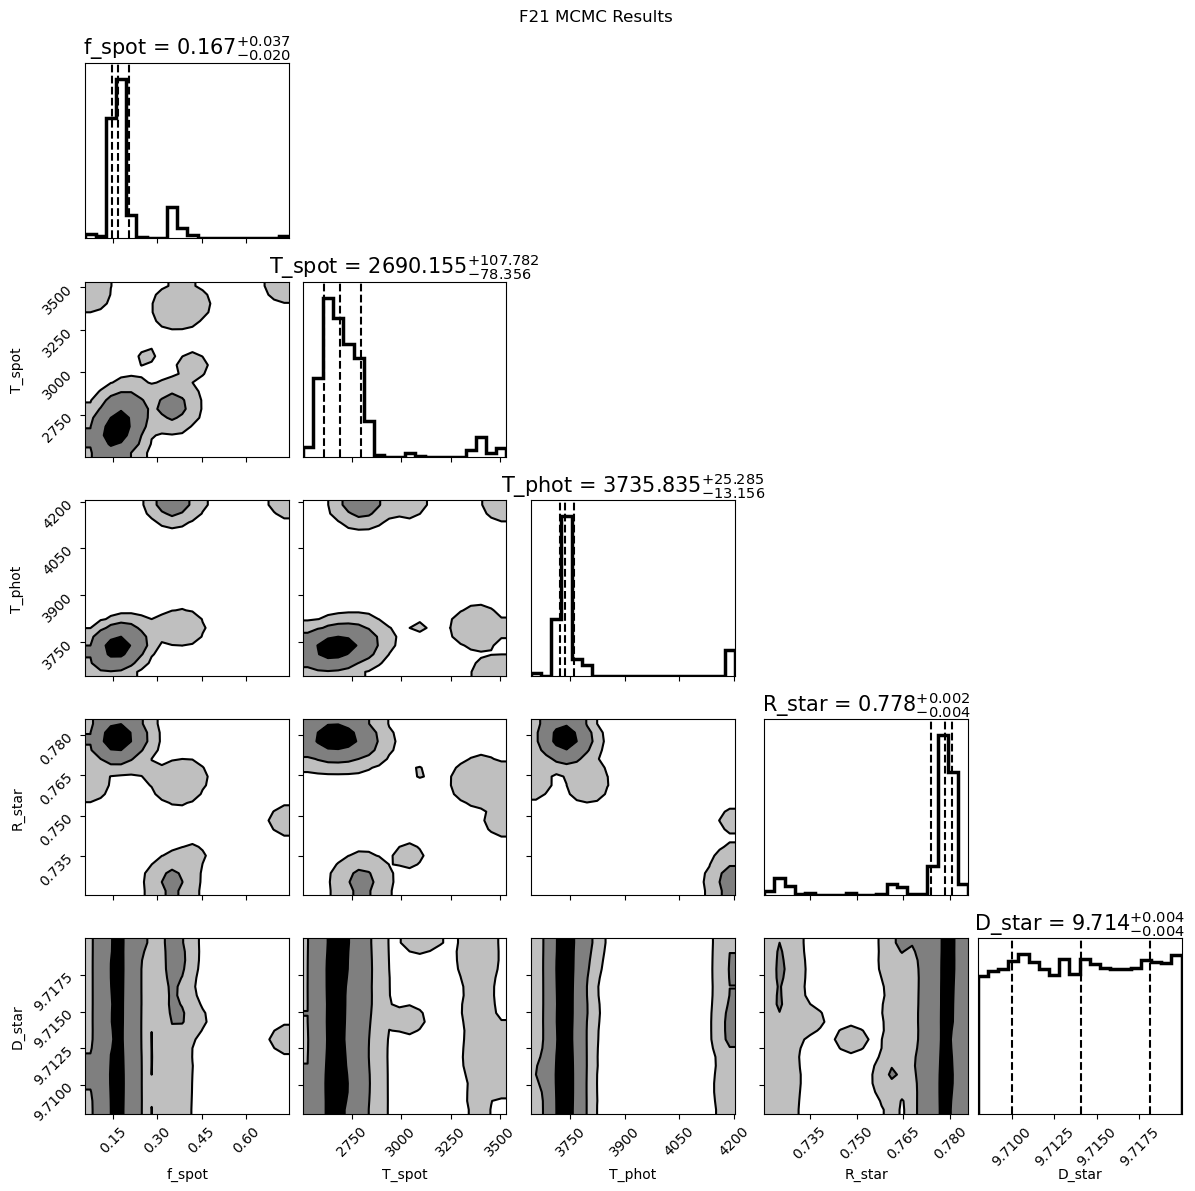

f_spot:
  Median (50th percentile): 0.17
  Lower 1-sigma uncertainty: 0.02
  Upper 1-sigma uncertainty: 0.04

T_spot:
  Median (50th percentile): 2690.2
  Lower 1-sigma uncertainty: 78.6
  Upper 1-sigma uncertainty: 108.3

T_phot:
  Median (50th percentile): 3735.83
  Lower 1-sigma uncertainty: 13.2
  Upper 1-sigma uncertainty: 25.6

R_star:
  Median (50th percentile): 0.78
  Lower 1-sigma uncertainty: 0.005
  Upper 1-sigma uncertainty: 0.002

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 892.25
Combined Reduced Chi-squared: 4.15
Combined Degrees of Freedom: 215


Processing S22 (both directions)

Running MCMC sampler...


100%|██████████| 10000/10000 [46:53<00:00,  3.55it/s]


(Nsteps-burnin)*nwalkers/tau= 241
(Nsteps-burnin)*nwalkers/tau= 144
(Nsteps-burnin)*nwalkers/tau= 247
(Nsteps-burnin)*nwalkers/tau= 247
(Nsteps-burnin)*nwalkers/tau= 1215


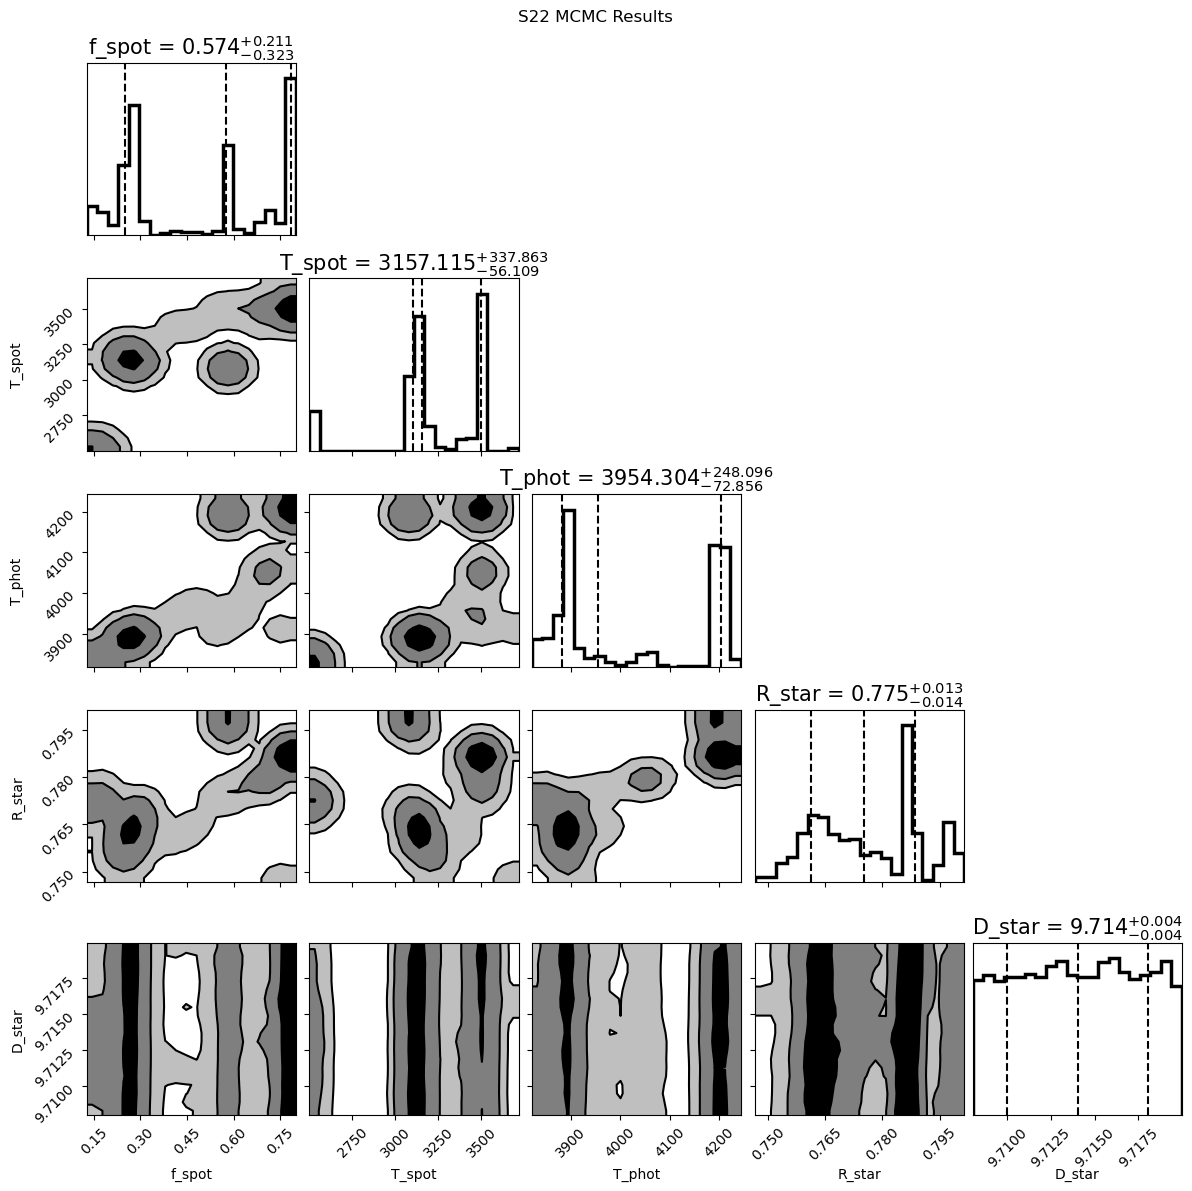

f_spot:
  Median (50th percentile): 0.57
  Lower 1-sigma uncertainty: 0.32
  Upper 1-sigma uncertainty: 0.21

T_spot:
  Median (50th percentile): 3157.1
  Lower 1-sigma uncertainty: 56.2
  Upper 1-sigma uncertainty: 337.9

T_phot:
  Median (50th percentile): 3954.30
  Lower 1-sigma uncertainty: 73.0
  Upper 1-sigma uncertainty: 248.1

R_star:
  Median (50th percentile): 0.78
  Lower 1-sigma uncertainty: 0.014
  Upper 1-sigma uncertainty: 0.013

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 193845.87
Combined Reduced Chi-squared: 784.80
Combined Degrees of Freedom: 247




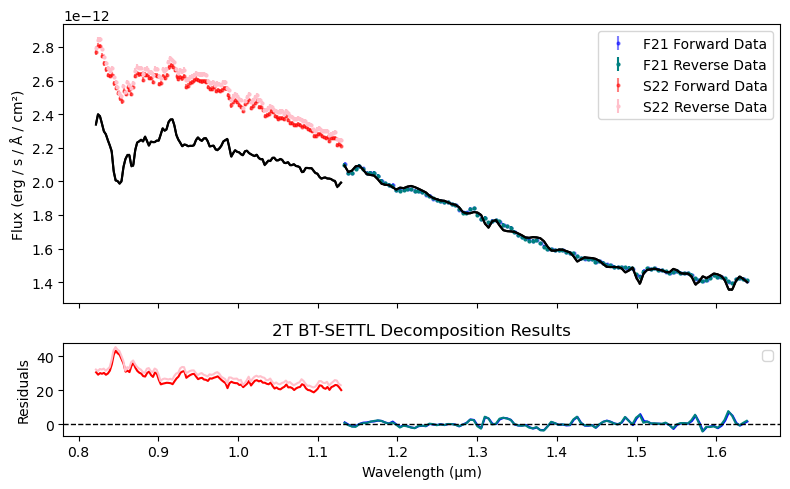

In [16]:
def lnprob(parameters=None,**kwargs):

    f_spot, T_spot, T_phot, R_star, D_star = parameters
    ln_like = 0

    c1 = 0.05<=f_spot<=0.8
    c2 = 2500 <= T_spot <= T_phot <= 4300
    c3 = 0.7 <= R_star <= 0.9
    c4 = (9.708 <= D_star <= 9.720)
    # Boundary conditions for parameters to ensure physical validity
    if ( c1 and c2 and c3 and c4 ):
        
        # Set parameters in lmfit
        model_params = lmfit.Parameters()
        model_params.add('f_spot', value=f_spot)
        model_params.add('T_spot', value=T_spot)
        model_params.add('T_phot', value=T_phot)
        model_params.add('R_star', value=R_star)
        model_params.add('D_star', value=D_star)
        solid_angle = (( (R_star * u.R_sun)/(D_star*u.parsec) ).decompose() )**2
        flux_model = spectral_model(model_params, filter_sigma)
        for direction in ['Forward','Reverse']:
            data_flux = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['f']
            data_wave= WFC3_Median_Spectra[f'{visit}'][f'{direction}']['w']
            data_err = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['e']
    
            # Generate model based on these parameters for both scan directions
            _model_flux = bintogrid(btsettl_wavelengths, flux_model, newx=data_wave.value)['y']
            model_flux = _model_flux * solid_angle
            # Calculate residuals and log-likelihood for both directions
            residuals = data_flux.value - model_flux
            err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err.value)))

            ln_like += (err_weight - 0.5*np.nansum((residuals / data_err.value) ** 2) )
                
        # Teff_model = ( f_spot*T_spot**4 + (1.0-f_spot)*T_phot**4 ) ** (1/4) 
        # chisq_Teff = (3650. - Teff_model)**2./(100.)**2.
        # err_weight_Teff = 1./np.sqrt(2.*np.pi*(100.))
        # ln_like += (err_weight_Teff - 0.5*chisq_Teff)
            
        return ln_like

    else:
        return -np.inf  # Return log-probability of -inf outside bounds

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 2
speclibrary = 'btsettl'
spectral_model = btsettl_2T
nwalkers = 150
nsteps = 10000

# Modify the loop to process both directions together
for visit in ['F21', 'S22']:
    print(f"Processing {visit} (both directions)\n")
    
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel

    flux_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['f']
    flux_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['f']

    wave_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['w']
    wave_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['w']

    err_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['e']
    err_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['e']

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(wave_fwd.value)
    all_data['calibrated_flux'].append(flux_fwd.value)
    all_data['calibrated_flux_err'].append(err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(wave_rev.value)
    all_data['calibrated_flux'].append(flux_rev.value)
    all_data['calibrated_flux_err'].append(err_rev.value)

    # MCMC setup
    """EDIT THESE LINES"""
    fspot_init = np.random.uniform(0.25,0.55,nwalkers)
    Tspot_init = np.random.uniform(2900,3300,nwalkers)
    Tphot_init = np.random.uniform(3800,4200,nwalkers)
    Rstar_init = np.random.uniform(0.8, 0.86, nwalkers)
    Dstar_init = np.random.uniform(9.712, 9.716, nwalkers)
    p0 = np.transpose([fspot_init, Tspot_init, Tphot_init, Rstar_init, Dstar_init])

    ndim = 5
    burnin = int(0.5*nsteps)
    """"""""""""""""""""""""
    
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnprob, 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    result = sampler.run_mcmc(p0, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',int((nsteps-burnin)*nwalkers/tau_f))
    
    # Make corner plot
    rng = 0.9995
    """EDIT THESE LINES"""
    variable_names = ['f_spot','T_spot','T_phot', 'R_star', 'D_star']
    """"""""""""""""""""""""
    fig = corner.corner( 
        samples.T,show_titles=True, labels=variable_names,
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    """EDIT THESE LINES"""
    f_spot_sam, T_spot_sam, T_phot_sam, R_star_sam, D_star_sam = samples
    sig1_f_spot = np.percentile(f_spot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_T_spot = np.percentile(T_spot_sam, [15.9, 50., 84.1]) 
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) 
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    sig1_D_star = np.percentile(D_star_sam, [15.9, 50., 84.1])
    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("f_spot:")
    print(f"  Median (50th percentile): {sig1_f_spot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_f_spot[1] - sig1_f_spot[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_f_spot[2] - sig1_f_spot[1]:.2f}")
    print("\nT_spot:")
    print(f"  Median (50th percentile): {sig1_T_spot[1]:.1f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_spot[1] - sig1_T_spot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_spot[2] - sig1_T_spot[1]:.1f}")
    print("\nT_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    print("\nD_star:")
    print(f"  Median (50th percentile): {sig1_D_star[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_D_star[1] - sig1_D_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_D_star[2] - sig1_D_star[1]:.3f}")
    
    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('f_spot', value=sig1_f_spot[1])
    mcmc_model_params.add('T_spot', value=sig1_T_spot[1])
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])
    mcmc_model_params.add('D_star', value=sig1_D_star[1])
    """"""""""""""""""""""""

    # Calculate the max likelihood model for both scan directions
    solid_angle = (( (sig1_R_star[1] * u.R_sun)/(sig1_D_star[1]*u.parsec) ).decompose() )**2
    best_model = spectral_model(mcmc_model_params, filter_sigma) * solid_angle 
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(btsettl_wavelengths, best_model, newx=wave_fwd.value)['y']
    model_flux_mcmc_rev = bintogrid(btsettl_wavelengths, best_model, newx=wave_rev.value)['y']

    # Calculate residuals for both scan directions
    residuals_fwd = flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = flux_rev.value - model_flux_mcmc_fwd
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / err_fwd.value,
        residuals_rev / err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(flux_fwd.value) + len(flux_rev.value)
    dof_combined = total_data_points - ndim
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

#### Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]
plt.title(f'{ncomponents}T BT-SETTL Decomposition Results')

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()

# 2T PHOENIX Models

Processing F21 (both directions)

Running MCMC sampler...


100%|██████████| 10000/10000 [1:10:47<00:00,  2.35it/s]


(Nsteps-burnin)*nwalkers/tau= 4211
(Nsteps-burnin)*nwalkers/tau= 257
(Nsteps-burnin)*nwalkers/tau= 119
(Nsteps-burnin)*nwalkers/tau= 221
(Nsteps-burnin)*nwalkers/tau= 2123
(Nsteps-burnin)*nwalkers/tau= 5603


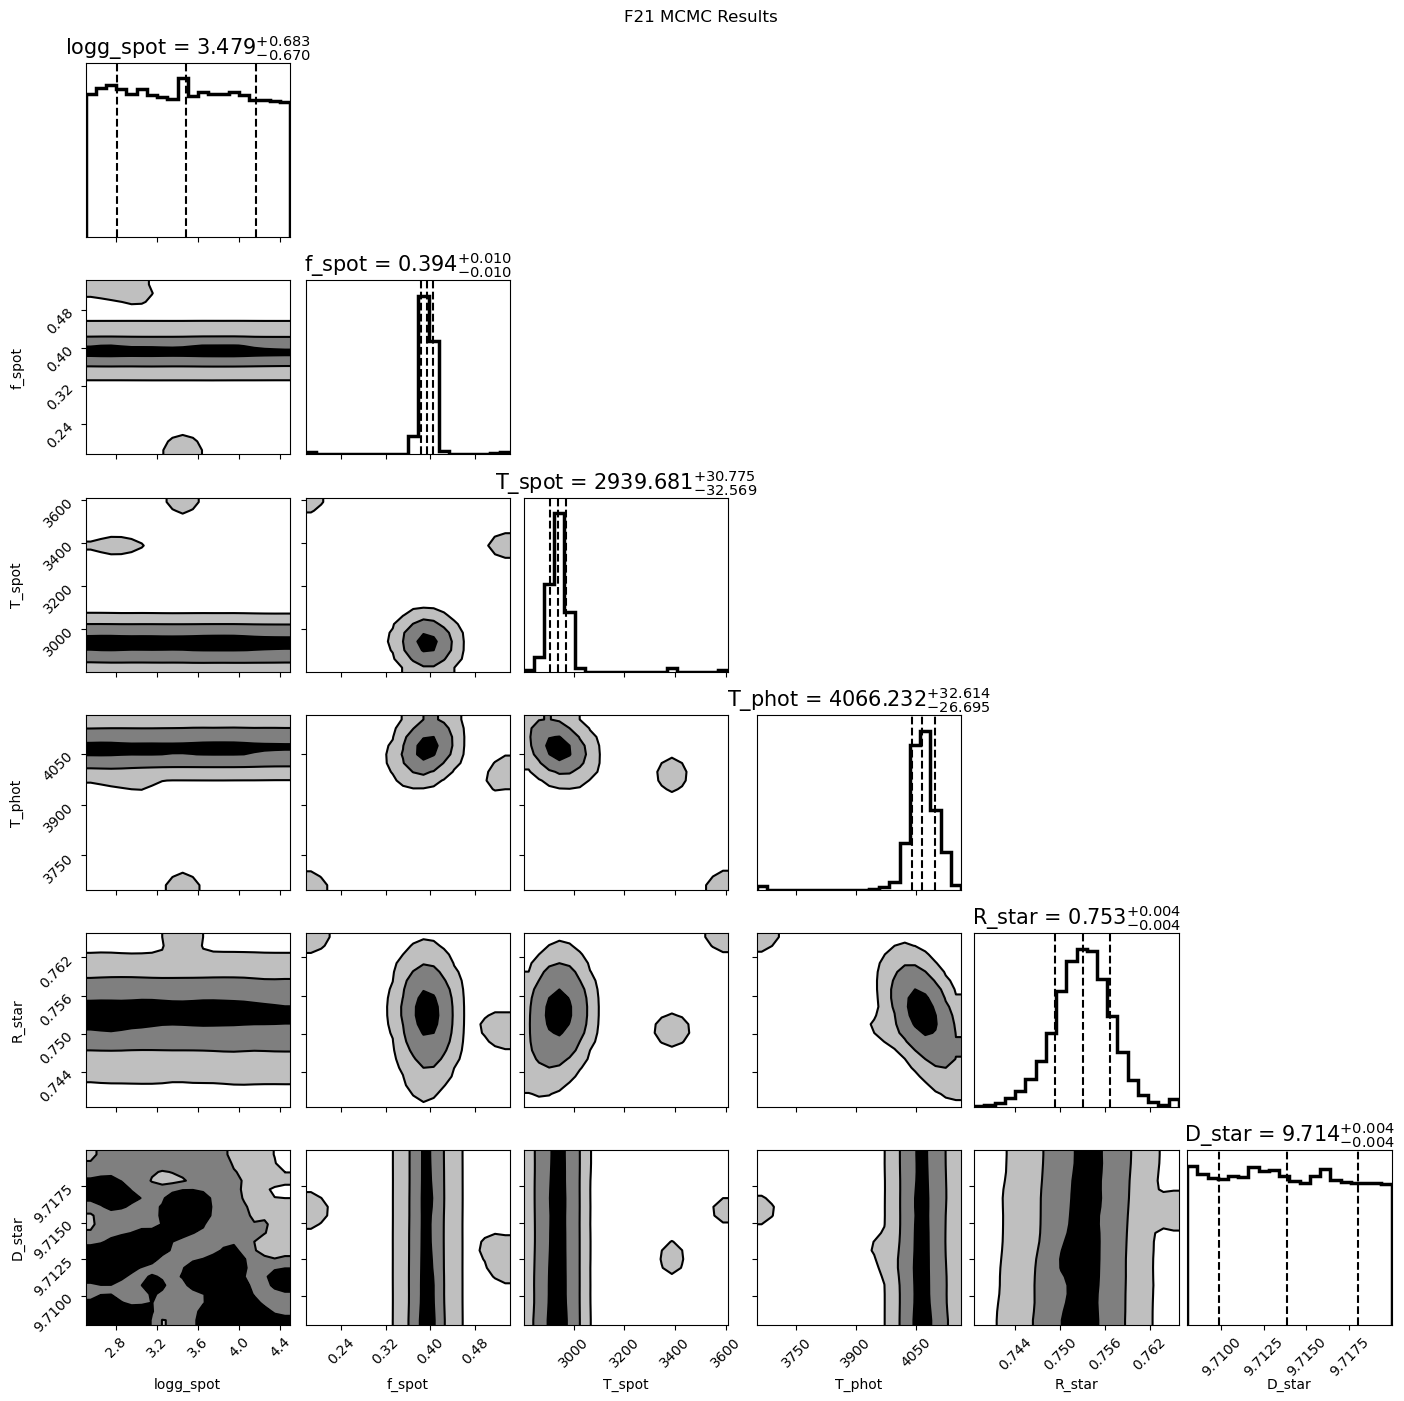

logg_spot:
  Median (50th percentile): 3.48
  Lower 1-sigma uncertainty: 0.67
  Upper 1-sigma uncertainty: 0.69

f_spot:
  Median (50th percentile): 0.39
  Lower 1-sigma uncertainty: 0.01
  Upper 1-sigma uncertainty: 0.01

T_spot:
  Median (50th percentile): 2939.7
  Lower 1-sigma uncertainty: 32.7
  Upper 1-sigma uncertainty: 30.9

T_phot:
  Median (50th percentile): 4066.23
  Lower 1-sigma uncertainty: 26.8
  Upper 1-sigma uncertainty: 32.8

R_star:
  Median (50th percentile): 0.75
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 510.89
Combined Reduced Chi-squared: 2.39
Combined Degrees of Freedom: 214


Processing S22 (both directions)

Running MCMC sampler...


100%|██████████| 10000/10000 [1:10:26<00:00,  2.37it/s]


(Nsteps-burnin)*nwalkers/tau= 1847
(Nsteps-burnin)*nwalkers/tau= 107
(Nsteps-burnin)*nwalkers/tau= 190
(Nsteps-burnin)*nwalkers/tau= 147
(Nsteps-burnin)*nwalkers/tau= 2008
(Nsteps-burnin)*nwalkers/tau= 1693


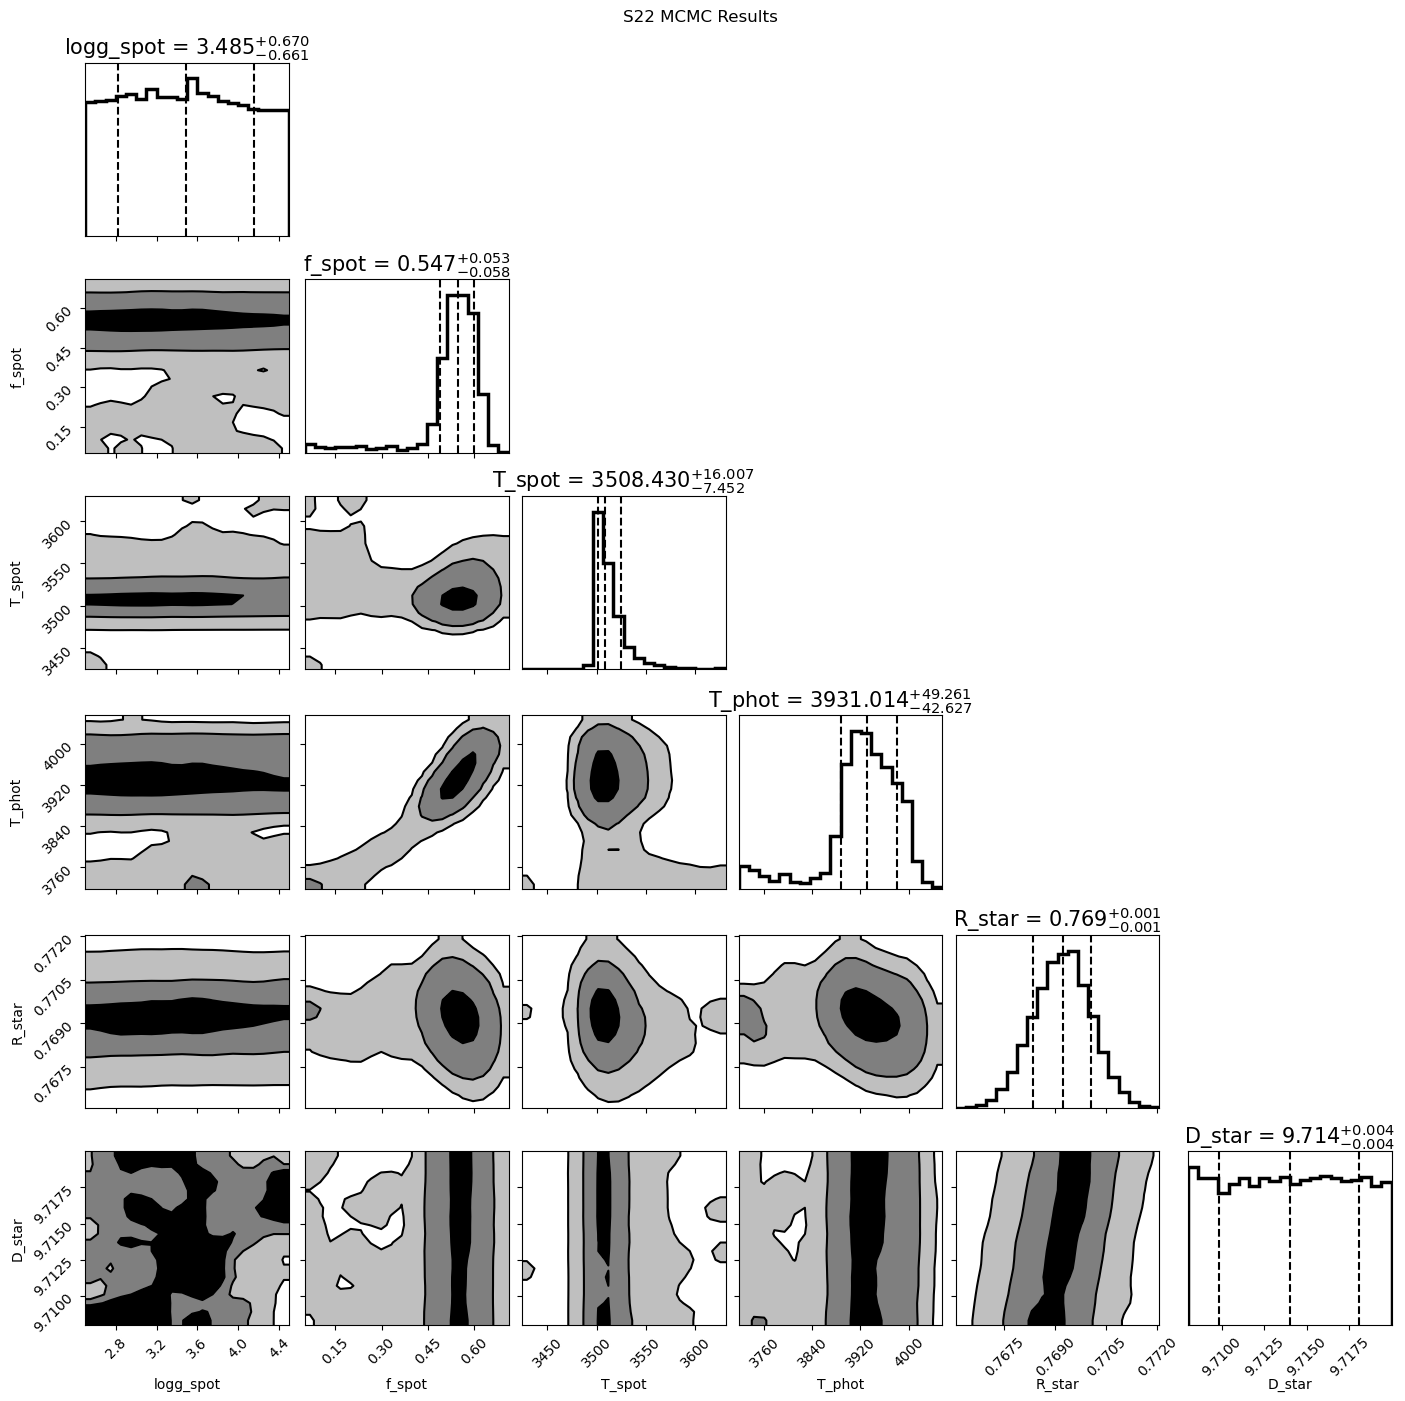

logg_spot:
  Median (50th percentile): 3.48
  Lower 1-sigma uncertainty: 0.66
  Upper 1-sigma uncertainty: 0.67

f_spot:
  Median (50th percentile): 0.55
  Lower 1-sigma uncertainty: 0.06
  Upper 1-sigma uncertainty: 0.05

T_spot:
  Median (50th percentile): 3508.4
  Lower 1-sigma uncertainty: 7.5
  Upper 1-sigma uncertainty: 16.1

T_phot:
  Median (50th percentile): 3931.01
  Lower 1-sigma uncertainty: 42.9
  Upper 1-sigma uncertainty: 49.5

R_star:
  Median (50th percentile): 0.77
  Lower 1-sigma uncertainty: 0.001
  Upper 1-sigma uncertainty: 0.001

D_star:
  Median (50th percentile): 9.71
  Lower 1-sigma uncertainty: 0.004
  Upper 1-sigma uncertainty: 0.004
Combined Chi-squared: 1717.52
Combined Reduced Chi-squared: 6.98
Combined Degrees of Freedom: 246




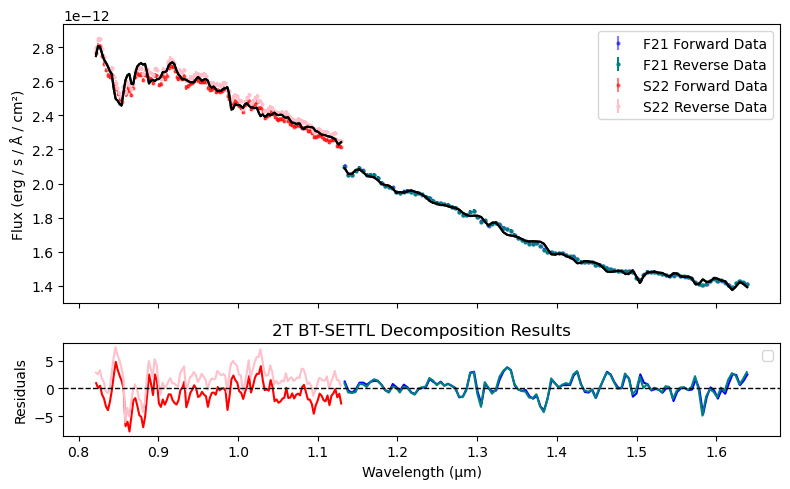

In [11]:
def lnprob(parameters=None,**kwargs):

    logg_spot, f_spot, T_spot, T_phot, R_star, D_star = parameters
    ln_like = 0
    
    c1 = (0.05<=f_spot<=0.95)
    c2 = (2500 <= T_spot <= T_phot <= 4300)
    c3 = (0.7 <= R_star <= 0.9)
    c4 = (9.708 <= D_star <= 9.720)
    c5 = (2.5 <= logg_spot <= 4.5)
    # Boundary conditions for parameters to ensure physical validity
    if ( c1 and c2 and c3 and c4 and c5):
        
        # Set parameters in lmfit
        model_params = lmfit.Parameters()
        model_params.add('logg_spot', value=logg_spot)
        model_params.add('f_spot', value=f_spot)
        model_params.add('T_spot', value=T_spot)
        model_params.add('T_phot', value=T_phot)
        model_params.add('R_star', value=R_star)
        model_params.add('D_star', value=D_star)
        solid_angle = (( (R_star * u.R_sun)/(D_star*u.parsec) ).decompose() )**2
        flux_model = spectral_model(model_params, filter_sigma)
        
        for direction in ['Forward','Reverse']:
            data_flux = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['f']
            data_wave= WFC3_Median_Spectra[f'{visit}'][f'{direction}']['w']
            data_err = WFC3_Median_Spectra[f'{visit}'][f'{direction}']['e']
    
            # Generate model based on these parameters for both scan directions
            _model_flux = bintogrid(model_wavelengths.value, flux_model, newx=data_wave.value)['y']
            model_flux = _model_flux * solid_angle
            # Calculate residuals and log-likelihood for both directions
            residuals = data_flux.value - model_flux
            err_weight = np.nansum(1./np.sqrt(2.*np.pi*(data_err.value)))

            ln_like += (err_weight - 0.5*np.nansum((residuals / data_err.value) ** 2) )
                
        # Teff_model = ( f_spot*T_spot**4 + (1-f_spot)*T_phot**4 ) ** (1/4) 
        # chisq_Teff = (3675. - Teff_model)**2./(100.)**2.
        # err_weight_Teff = 1./np.sqrt(2.*np.pi*(100.))
        # ln_like += (err_weight_Teff - 0.5*chisq_Teff)
            
        return ln_like

    else:
        return -np.inf  # Return log-probability of -inf outside bounds

# Collect all visit data for plotting
all_data = {
    'visit': [],
    'direction': [],
    'wavelength': [],
    'calibrated_flux': [],
    'calibrated_flux_err': [],
    'model_flux': [],
    'residuals': [],
    'samples': []
}
results_table = []

"""
SET PARAMETERS FOR LABELS AND FILESAVING
"""
ncomponents = 2
speclibrary = 'phoenix'
spectral_model = phoenix_2T
nwalkers = 150
nsteps = 10000


# Modify the loop to process both directions together
for visit in ['F21', 'S22']:
    print(f"Processing {visit} (both directions)\n")
    
    if visit=='F21':
        filter_sigma = 5.0 * u.pixel
    if visit=='S22':
        filter_sigma = 2.5 * u.pixel

    flux_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['f']
    flux_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['f']

    wave_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['w']
    wave_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['w']

    err_fwd = WFC3_Median_Spectra[f'{visit}']['Forward']['e']
    err_rev = WFC3_Median_Spectra[f'{visit}']['Reverse']['e']

    # Store data for plotting for the forward scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Forward')
    all_data['wavelength'].append(wave_fwd.value)
    all_data['calibrated_flux'].append(flux_fwd.value)
    all_data['calibrated_flux_err'].append(err_fwd.value)
    
    # Store data for plotting for the reverse scan
    all_data['visit'].append(f'{visit}')
    all_data['direction'].append('Reverse')
    all_data['wavelength'].append(wave_rev.value)
    all_data['calibrated_flux'].append(flux_rev.value)
    all_data['calibrated_flux_err'].append(err_rev.value)

    # MCMC setup
    """EDIT THESE LINES"""
    loggspot_init = np.random.uniform(3.0,4.5,nwalkers)
    fspot_init = np.random.uniform(0.25,0.55,nwalkers)
    Tspot_init = np.random.uniform(2900,3400,nwalkers)
    Tphot_init = np.random.uniform(3700,4100,nwalkers)
    Rstar_init = np.random.uniform(0.7, 0.9, nwalkers)
    Dstar_init = np.random.uniform(9.712, 9.716, nwalkers)
    p0 = np.transpose([loggspot_init, fspot_init, Tspot_init, Tphot_init, Rstar_init, Dstar_init])

    ndim = 6
    burnin = int(0.5*nsteps)
    """"""""""""""""""""""""
    
    label=f'{visit}_{nsteps}steps_{ncomponents}T_{speclibrary}_specmodel'
    samples_fname = f"../data/samples/{label}.h5"
    backend = emcee.backends.HDFBackend(samples_fname)
    backend.reset(nwalkers, ndim)        
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lnprob, 
        backend=backend)

    # Run the MCMC sampler
    print('Running MCMC sampler...')
    result = sampler.run_mcmc(p0, nsteps, store=True, progress=True)
    samples = sampler.chain[:, burnin:, :].reshape((-1, ndim)).T
    all_data['samples'].append(samples)

    # Check for convergence (all should be > 100)
    for i in range(len(samples)):
        tau_f = emcee.autocorr.integrated_time(samples[i])
        print('(Nsteps-burnin)*nwalkers/tau=',int((nsteps-burnin)*nwalkers/tau_f))
    
    # Make corner plot
    rng = 0.9995
    """EDIT THESE LINES"""
    variable_names = ['logg_spot','f_spot','T_spot','T_phot', 'R_star', 'D_star']
    """"""""""""""""""""""""
    fig = corner.corner( 
        samples.T,show_titles=True, labels=variable_names,
        range=[rng]*ndim,smooth=1,quantiles=(0.16, 0.5, 0.84),
        fill_contours=True, plot_datapoints=False,title_kwargs={"fontsize": 15},title_fmt='.3f',
        hist_kwargs={"linewidth": 2.5},levels=[(1-np.exp(-0.5)),(1-np.exp(-2)),(1-np.exp(-4.5))])
    plt.suptitle(f"{visit} MCMC Results")
    plt.savefig(f'../figs/{visit}_{nsteps}nsteps_{ncomponents}T_{speclibrary}_specmodel_corner.png')
    plt.show()

    # Calculate best-fit model flux from MCMC results
    """EDIT THESE LINES"""
    logg_spot_sam, f_spot_sam, T_spot_sam, T_phot_sam, R_star_sam, D_star_sam = samples
    sig1_logg_spot = np.percentile(logg_spot_sam, [15.9, 50., 84.1]) # central 1-sigma values
    sig1_f_spot = np.percentile(f_spot_sam, [15.9, 50., 84.1]) 
    sig1_T_spot = np.percentile(T_spot_sam, [15.9, 50., 84.1]) 
    sig1_T_phot = np.percentile(T_phot_sam, [15.9, 50., 84.1]) 
    sig1_R_star = np.percentile(R_star_sam, [15.9, 50., 84.1])
    sig1_D_star = np.percentile(D_star_sam, [15.9, 50., 84.1])
    
    # Print the 50th percentile (median) and 1-sigma uncertainties for each parameter
    print("logg_spot:")
    print(f"  Median (50th percentile): {sig1_logg_spot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_logg_spot[1] - sig1_logg_spot[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_logg_spot[2] - sig1_logg_spot[1]:.2f}")
    print("\nf_spot:")
    print(f"  Median (50th percentile): {sig1_f_spot[1]:.2f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_f_spot[1] - sig1_f_spot[0]:.2f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_f_spot[2] - sig1_f_spot[1]:.2f}")
    print("\nT_spot:")
    print(f"  Median (50th percentile): {sig1_T_spot[1]:.1f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_spot[1] - sig1_T_spot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_spot[2] - sig1_T_spot[1]:.1f}")
    print("\nT_phot:")
    print(f"  Median (50th percentile): {sig1_T_phot[1]:.1f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_T_phot[1] - sig1_T_phot[0]:.1f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_T_phot[2] - sig1_T_phot[1]:.1f}")
    print("\nR_star:")
    print(f"  Median (50th percentile): {sig1_R_star[1]:.3f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_R_star[1] - sig1_R_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_R_star[2] - sig1_R_star[1]:.3f}")
    print("\nD_star:")
    print(f"  Median (50th percentile): {sig1_D_star[1]:.3f}")
    print(f"  Lower 1-sigma uncertainty: {sig1_D_star[1] - sig1_D_star[0]:.3f}")
    print(f"  Upper 1-sigma uncertainty: {sig1_D_star[2] - sig1_D_star[1]:.3f}")

    # Set parameters in lmfit
    mcmc_model_params = lmfit.Parameters()
    mcmc_model_params.add('logg_spot', value=sig1_logg_spot[1])
    mcmc_model_params.add('f_spot', value=sig1_f_spot[1])
    mcmc_model_params.add('T_spot', value=sig1_T_spot[1])
    mcmc_model_params.add('T_phot', value=sig1_T_phot[1])
    mcmc_model_params.add('R_star', value=sig1_R_star[1])
    mcmc_model_params.add('D_star', value=sig1_D_star[1])
    """"""""""""""""""""""""

    # Calculate the max likelihood model for both scan directions
    solid_angle = (( (sig1_R_star[1] * u.R_sun)/(sig1_D_star[1]*u.parsec) ).decompose() )**2
    best_model = spectral_model(mcmc_model_params, filter_sigma) * solid_angle
    
    # Generate binned model fluxes for both scan directions
    model_flux_mcmc_fwd = bintogrid(model_wavelengths.value, best_model, newx=wave_fwd.value)['y']
    model_flux_mcmc_rev = bintogrid(model_wavelengths.value, best_model, newx=wave_rev.value)['y']

    # Calculate residuals for both scan directions
    residuals_fwd = flux_fwd.value - model_flux_mcmc_fwd
    residuals_rev = flux_rev.value - model_flux_mcmc_fwd
    
    # Append residuals for plotting
    all_data['model_flux'].append(model_flux_mcmc_fwd)
    all_data['model_flux'].append(model_flux_mcmc_rev)
    all_data['residuals'].append(residuals_fwd)
    all_data['residuals'].append(residuals_rev)
    
    # Calculate combined chi-squared and reduced chi-squared
    combined_residuals = np.concatenate([
        residuals_fwd / err_fwd.value,
        residuals_rev / err_rev.value
    ])
    chisq_combined = np.nansum(combined_residuals ** 2)
    total_data_points = len(flux_fwd.value) + len(flux_rev.value)
    dof_combined = total_data_points - ndim
    
    # Calculate reduced chi-squared
    reduced_chisq_combined = chisq_combined / dof_combined
    
    # Print combined chi-squared statistics
    print(f"Combined Chi-squared: {chisq_combined:.2f}")
    print(f"Combined Reduced Chi-squared: {reduced_chisq_combined:.2f}")
    print(f"Combined Degrees of Freedom: {dof_combined}")
    print("\n")

#### Plot all data, models, and residuals on a single plot
fig, (ax, ax_residuals) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8, 5), sharex=True)
colors = ['blue', 'teal', 'red', 'pink']
alphas = [0.5, 1.0, 0.5, 1.0]
plt.title(f'{ncomponents}T BT-SETTL Decomposition Results')

for i, (visit, direction, wavelength, data_flux, data_err, model_flux, residual) in enumerate(zip(
    all_data['visit'], all_data['direction'], all_data['wavelength'], all_data['calibrated_flux'], 
    all_data['calibrated_flux_err'], all_data['model_flux'], all_data['residuals'])):
    
    color = colors[i % len(colors)]
    ax.errorbar(wavelength, data_flux, yerr=data_err, fmt='o', color=color, ms=2, label=f'{visit} {direction} Data', alpha=alphas[i])
    ax.plot(wavelength, model_flux, color='k',zorder=1000)
    ax_residuals.plot(wavelength, residual / data_err, color=color)

# Plot configuration
ax.set_ylabel('Flux (erg / s / Å / cm²)')
ax.legend()
ax_residuals.axhline(0, color='black', linestyle='--', linewidth=1)
ax_residuals.set_ylabel('Residuals')
ax_residuals.set_xlabel('Wavelength (μm)')
ax_residuals.legend()

plt.tight_layout()
plt.savefig(f'../figs/{ncomponents}T_{speclibrary}_spectral_resultsplot.png')
plt.show()